# Intro
in this notebook we are going to implement a single layer FC layer followed with tanh nonlinearity. we will also build an embedding matrix that gonna be a part of our optimization

In [1]:
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
from tqdm import tqdm
%matplotlib inline



/home/abdelrahman.atef/anaconda3/envs/dl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('data/combined_english_names_cleaned.txt','r') as f:
    names = [x.strip().lower() for x in f.readlines()]
    
names[:10]
    

['abdelrahman',
 'albiloni',
 'wsamaiah',
 'sammar',
 'alrshidiah',
 'jllai',
 'aljroshi',
 'hazizah',
 'noshin',
 'akhdan']

In [3]:
len(names)

52813

In [4]:
chars = ['.'] + sorted(list(set(''.join(names))))
chars

['.',
 '-',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'y',
 'z']

In [5]:
stoi = { c:i for i,c in enumerate(chars)}


itos = {i:c for c,i in stoi.items()}

print(stoi)
print(itos)


{'.': 0, '-': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'y': 25, 'z': 26}
{0: '.', 1: '-', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'y', 26: 'z'}


## Building Dataset
 The idea is to create a dataset from the names, by creating a context, target pairs

In [6]:
def build_dataset(context_size, names, p=False):
    X = []
    Y = []

    for name in names:

        if p :
            print(name)
        context = [stoi['.']] * context_size

        for c in name + '.':
            X.append(context)
            Y.append(stoi[c])

            if p:
                print( ''.join(itos[x] for x in context) ,f' --> {c}')

            context = context[1:] + [stoi[c]]

    
    X = torch.tensor(X)
    Y = torch.tensor(Y)


    return X,Y

In [7]:
# X, Y = build_dataset(3,names)
# print(X.shape)
# X_embedd = embedding[X]
# X_embedd.shape

In [8]:
import random
random.shuffle(names)
CONTEXT_SIZE = 3
threshold_1 = int(0.8 * len(names))
threshold_2 = int(0.9 * len(names))

X_train, Y_train  = build_dataset(CONTEXT_SIZE, names[: threshold_1])
X_dev, Y_dev  = build_dataset(CONTEXT_SIZE, names[threshold_1 : threshold_2])
X_test, Y_test  = build_dataset(CONTEXT_SIZE, names[threshold_2:])


In [9]:
print(len(names))
print(X_train.shape, Y_train.shape)
print(X_dev.shape, Y_dev.shape)
print(X_test.shape, Y_test.shape)


52813
torch.Size([351530, 3]) torch.Size([351530])
torch.Size([43866, 3]) torch.Size([43866])
torch.Size([43764, 3]) torch.Size([43764])


In [10]:
EMBEDDING_SIZE = 10
embedding = torch.randn((len(chars), EMBEDDING_SIZE),requires_grad=True)
w1 = torch.randn(( EMBEDDING_SIZE * CONTEXT_SIZE,200),requires_grad=True)
b1 = torch.randn((200),requires_grad=True)
w2 = torch.randn((200,27),requires_grad=True)
b2 = torch.randn((27),requires_grad=True)

parameters = [embedding,w1,b1,w2,b2]

In [11]:
# X_embedd = X_embedd.view(X_embedd.shape[0], X_embedd.shape[1] *X_embedd.shape[2] )
# X_embedd.shape

In [12]:
def forward(input):
    input = input.view(-1,input.shape[1] * input.shape[2] )
    h =  torch.tanh(input @ w1 + b1)
    o = h @ w2 + b2
    # print(o.shape)
    logits =   o
    return logits

In [13]:
def back(loss,lr):

    for p in parameters:
        p.grad = None


    loss.backward(retain_graph=True)

    for p in parameters:
        p.data +=   -lr * p.grad





In [14]:
def train_epoch(data,y, lr=0.1):

    logits = forward(data)

    ## Note: we see that we can't fully overfit the datast, cause in the dataset, 
    ## we keep mapping the ... to different characters in every word
    # print('Prediction',logits.max(1)[1][:10])
    # print('Label     ',Y[:10])

    # This is equivalent to cross entropy loss 
    # nomalized_logits = torch.softmax(logits, dim=1)
    # loss =  - torch.mean(torch.log(nomalized_logits[range(Y.shape[0]),Y]))


    loss = F.cross_entropy(logits, y)
    # print(l2.item() , loss.item())
    back(loss,lr)
    
    return loss.item()

In [15]:
def generate_name():

    w = ''
    last_ch = [0]* 3
    while True:

        last_ch = torch.tensor(last_ch)

        embed = embedding[last_ch]
        embed = embed.unsqueeze(0)
        # embed = embed.view(-1,6)

        # print(embed.shape)
        logits = forward(embed)
        p = torch.softmax(logits, dim=1)



        next_ch = torch.multinomial(p, num_samples=1, replacement=True).item()

        last_ch = last_ch.tolist()
        last_ch = last_ch[1:] + [next_ch]

        w += itos[next_ch]

        if next_ch == 0:
            break

    return w

In [16]:
def eval(input, target):
    input = embedding[input]
    logits = forward(input)
    loss = F.cross_entropy(logits, target)
    
    return loss

In [17]:
lrs = torch.linspace(-3,0,1000)
lrs = 10**lrs

In [18]:
lri = []
lossi = []
steps = []

In [19]:
l = 0.0
EPOCHS = 400_000


for i in tqdm(range(EPOCHS)):
    
    batch_indexes = torch.randint(0,X_train.shape[0], (256,))
    
    batch = embedding[X_train[batch_indexes]]
    y = Y_train[batch_indexes]

    lr = 0.1 if i < 200_000 else 0.01

    # print(batch.shape, y.shape)
    cur_l = train_epoch(batch,y,lr)

    # l+= cur_l

    # lri.append(lrs[i])
    lossi.append(cur_l)
    steps.append(i)


    l = cur_l


# l = torch.tensor(l)
# print(l/ EPOCHS)

print(l)

100%|██████████| 400000/400000 [04:06<00:00, 1622.72it/s]

1.9866158962249756


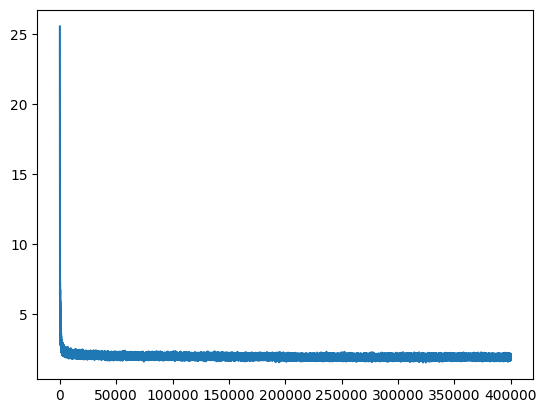

In [20]:
plt.plot(steps,lossi)

In [21]:
print(eval(X_train, Y_train))

print(eval(X_dev, Y_dev))

tensor(1.9033, grad_fn=<NllLossBackward0>)
tensor(1.9336, grad_fn=<NllLossBackward0>)


In [22]:
for i in range (5):
    print(generate_name())

altrqaoi.
abdelgal.
aliqah.
kafid.
cabderahminem.


In [23]:
## Number of params in the model
sum(p.nelement() for p in parameters)

11897

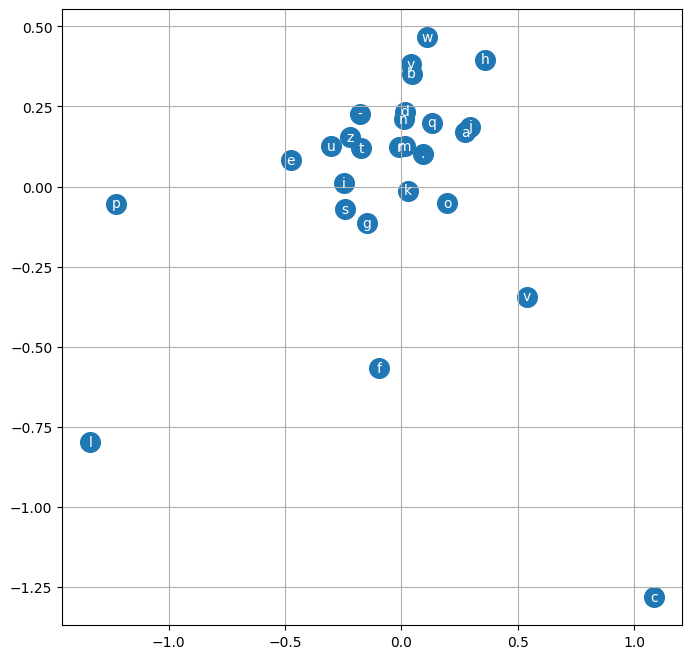

In [24]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(embedding[:,0].data, embedding[:,1].data, s=200)
for i in range(embedding.shape[0]):
    plt.text(embedding[i,0].item(), embedding[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')
